<a href="https://colab.research.google.com/github/nmningmei/mask_image_FOREST/blob/master/decode_EEG_via_baseline_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from IPython.display import Image

In [0]:
def get_data(file_id,file_name):
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.GetContentFile(f'{file_name}')

In [0]:
eeg_id = 'https://drive.google.com/open?id=1pIjvShObTC6VGkWKKdPS9kjtmUq05U7t'.split('id=')[-1]
get_data(eeg_id,'epochs.fif')

# experiment

## targets: living v.s. nonliving objects -- images

## conscious state: unconscious, glimpse, conscious

# preprocessing steps

## highpass filter at 0.0001 Hz

## linear detrend

# Baseline Model: Logistic Regression (C = 1, L2 panelty), cv = StratifiedShuffleSplit(n_splits = 300, test_size = 0.2)

## Decode living v.s. nonliving using the whole epoch as feature (n_sample x n_channels x n_timepoints)

## Decode living v.s. nonliving at each time point (n_sample x n_channels at each timepoint)

## Decode living v.s. nonliving at each time point and generalize to other time points - temporal generalization


# Baseline Model Results

## Unconscious

### Temporal Decoding

In [5]:
Image(url = 'https://raw.githubusercontent.com/nmningmei/mask_image_FOREST/master/figures/EEG/decode/mattin_7_12_2019/temporal%20decoding%20(unconscious).png',
     height = 500)

### Temporal Generalization

In [6]:
Image(url = 'https://raw.githubusercontent.com/nmningmei/mask_image_FOREST/master/figures/EEG/decode/mattin_7_12_2019/temporal%20generalization%20(unconscious).png',
     height = 500)

In [7]:
Image(url = 'https://raw.githubusercontent.com/nmningmei/mask_image_FOREST/master/figures/EEG/decode/mattin_7_12_2019/stats%20(p%20values%2C%20unconscious).png',
     height = 500)

# RNN - 1 layer, 1 unit

## Rationale to use RNN instead of the baseline model: complexity and temporal dynamics

### complexity of the model:
When fitting the baseline model to the data, each instance is 60 channels x 150 time points, after downsampling from 1000 Hz to 100 Hz. This means we will have to fit 60 x 150 = 9000 parameters to find the boundary that discriminate living v.s. nonliving categories. When we perform temporal decoding and/or temporal generalization, it is essentially the same thing, except the parameters to fit are divided into 150 parts, and for each part, we will fit 60 parameters. 

For a 1 layer and 1 unit RNN, you will see it has around 500 parameters (16 times smaller) to fit when the input dimension is 60 x 150. That is because we consider the channels to be the "embedding features" and the embedding was performed along the 150 time steps. We re-formulate the EEG decoding problem to a natural language processing modelling problem. 

### temporal dynamics
As we know, RNN is good for temporal dynamics modelling, being better than logistic regressions. 

## lots of helper functions

In [8]:
!pip install mne

In [0]:
import mne
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Model, optimizers,losses,regularizers,callbacks#,Sequential
from tensorflow.keras import metrics as k_metrics
import tensorflow.keras.backend as K
from collections import Counter
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

In [0]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
    """
    Make call back function lists for the keras models
    
    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor: the criterion we used for saving or stopping the model
    mode: min --> lower the better, max --> higher the better
    verboser: printout the monitoring messages
    min_delta: minimum change for early stopping
    patience: temporal windows of the minimum change monitoring
    frequency: temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint: saving the best model
    EarlyStopping: early stoppi....
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 save_freq        = frequency,# frequency of check the update 
                                 verbose          = verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]
def preprocess_features(X,vectorizer = None,scaler = None):
    if vectorizer is None:
        vectorizer          = mne.decoding.Vectorizer()
        X_vec               = vectorizer.fit_transform(X)
    else:
        X_vec               = vectorizer.transform(X)
    if scaler is None:
        scaler              = StandardScaler()
        X_vec_standard      = scaler.fit_transform(X_vec)
    else:
        X_vec_standard      = scaler.transform(X_vec)
    X_vec_tran          = vectorizer.inverse_transform(X_vec_standard)
    
    return X_vec_tran,vectorizer,scaler
def prepare_data_batch(X,y,batch_size = 32):
    """
    prepare the data for training, validating, and testing
    make sure the data in a certain range and fit to the batch size
    
    Inputs 
    -------------------------------
    X: input features, (n_sample x n_channels x n_timesteps)
    y: input labels, (n_samples x n_categories)
    batch_size: int, batch size
    Return
    -------------------------------
    processed X,y
    """
    X       = X / np.abs(X.max())
    remain_ = X.shape[0] % batch_size
    if remain_ != 0:
        np.random.seed(12345)
        idx_    = np.random.choice(X.shape[0],size = X.shape[0] - remain_)
        X,y     = X[idx_],y[idx_]
        
    return X,y
def call_back_dict(classifier,care = 'loss'):
    if care == 'loss':
        return dict(
                monitor     = 'val_{}'.format(classifier.metrics_names[0]),
                mode        = 'min',
                patience    = 3,
                min_delta   = 1e-3)
    elif care == 'metric':
        return dict(
                monitor     = 'val_{}'.format(classifier.metrics_names[-1]),
                mode        = 'max',
                patience    = 4,
                min_delta   = 1e-4)
    else:
        print('why?')

def build_model(timesteps,
                data_dim,
                n_units     = 1,
                batch_size  = 32,
                n_layers    = 1,
                drop        = True,
                l1          = 1e-2,
                l2          = 1e-2,):
    """
    initialize a RNN model
    
    Inputs
    -----------------------------------------------
    timesteps: int, length of time steps
    data_dim: int, number of features, such as n_channels
    n_units: int, number of RNN units, each unit has the same number of cells as the number of time steps
    batch_size: int, batch size
    n_layers: int, number of RNN layers, this is independent from the number of units
    drop: bool, extra dropout layer
    l1: float, L1 penalty, higher is more sparse
    l2: float, L2 penalty, higher is lower the magnitude of the weights
    """
    K.clear_session()
    inputs          = layers.Input(
                                   shape        = (timesteps,data_dim,),
                                   batch_size   = batch_size,# keras way (batch_size,timesteps,data_dim),
                                   name         = 'inputs')
    # if we want to make multiple layers, I am not going to use the "inputs" tensor because this has to be the "Input" object without any chance
    # this will make a copy of it
    inputs_         = inputs
    # first RNN layer
    RNN,state_h = layers.GRU(units              = n_units,
                             return_state       = True,
                             return_sequences   = True,
                             kernel_regularizer = regularizers.l2(l2),
                             name               = 'rnn{}'.format(1))(inputs_)
    RNN         = layers.BatchNormalization(
                             name               = 'norm{}'.format(1))(RNN)
    if n_layer < 2: # don't need to do this if it is not the only RNN layer
        if n_units == 1:
            # if we define only 1 RNN unit, the last dimension of the output would be 1
            # thus, if this is the only layer, we could squeeze the 1 out
            RNN         = layers.Lambda(lambda x: K.squeeze(x, 2))(RNN)
        else:
            # otherwise, we will have the RNN outputs from multiple units
            # then, we could find the averages over these units
            # make sure you will average over the last dimension
            RNN         = layers.GlobalAveragePooling1D(data_format = 'channels_first',
                                                        name = 'pool_units{}'.format(1))(RNN)
    for n_temp in range(n_layers - 1):
        l1 /= 10
        l2 /= 10
        RNN,state_h = layers.GRU(units              = n_units,
                                 return_state       = True,
                                 return_sequences   = True,
                                 dropout            = 0.1,
                                 recurrent_dropout  = 0.25,
                                 kernel_regularizer = regularizers.l2(l2),
                                 name               = 'rnn{}'.format(n_temp + 2))(RNN,initial_state = [state_h])
        RNN         = layers.BatchNormalization(
                                 name               = 'norm{}'.format(n_temp + 2))(RNN)
        if n_temp == n_layers - 1: # perform dimension check for last RNN layer
            if n_units == 1:
                RNN         = layers.Lambda(lambda x: K.squeeze(x, 2))(RNN)
            else:
                RNN         = layers.GlobalAveragePooling1D(data_format = 'channels_first',
                                                            name = 'pool_units{}'.format(n_temp + 2))(RNN)
        if drop:
            RNN         = layers.Dropout(0.25,
                                         name           = 'drop{}'.format(n_temp + 2))(RNN)
    # connect the RNN with a dense layer - the most parameter consuming layer
    outputs             = layers.Dense(2,
                                       activation           = 'softmax',
                                       activity_regularizer = regularizers.l1(1e-6),
                                       name                 = 'outputs',)(RNN)
    classifier = Model(inputs,outputs,name = 'clf')
    return classifier

In [15]:
epochs  = mne.read_epochs('epochs.fif')
# resample at 100 Hz to fasten the decoding process
print('resampling')
epochs.resample(100)

conscious   = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if (' conscious' in name)])
see_maybe   = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if ('glimpse' in name)])
unconscious = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if ('unconscious' in name)])
del epochs

Reading epochs.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available


<ipython-input-15-4aee22227091>:1: RuntimeWarning: This filename (epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs  = mne.read_epochs('epochs.fif')


1728 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
resampling
235 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
975 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
518 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


## ??

In [0]:
n_splits            = 25
n_epochs            = int(2e2)
print_model         = True

## cross validation process

In [17]:
results = []
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                  see_maybe.copy(),
                                                  conscious.copy()],
                                                 ['unconscious',
#                                                  'glimpse',
#                                                  'conscious'
                                                 ])):
    epochs
    epochs = epochs.pick_types(eeg=True)

    X_,y_               = epochs.get_data(),epochs.events[:,-1]
    y_                  = y_ //100 - 2
    X,targets           = X_.copy(),y_.copy()
    targets             = np.vstack([targets,1-targets]).T

    X                   = mne.decoding.Scaler(epochs.info).fit_transform(X)
    # because RNN take input's last dimension as the feature while the second the last dimension as time step
    X                   = np.swapaxes(X,1,2)
    ss                  = []
    cv                  = StratifiedShuffleSplit(n_splits=n_splits,test_size = 0.15,random_state=12345)
    for fold,(idx_,idx_test) in enumerate(cv.split(X,targets)):

        X_train,X_valid,y_train,y_valid = train_test_split(
                            X[idx_],targets[idx_],
                            test_size           = 0.15,
                            random_state        = 12345,
                            shuffle             = True,)

        model_name  = 'RNN.hdf5'
        batch_size  = 10
        timesteps   = X.shape[1]
        data_dim    = X.shape[2]
        n_units     = 1
        n_layers    = 1
        dropout     = True
        # make the model
        classifier = build_model(timesteps   = timesteps,
                                            data_dim    = data_dim,
                                            n_units     = n_units,
                                            batch_size  = batch_size,
                                            n_layers    = n_layers,
                                            drop        = dropout)
        print(f'the model has {classifier.count_params()} parameters')
        if print_model:
            classifier.summary()
            print_model = False
        # compile the model with optimizer, loss function
        classifier.compile(optimizer                = optimizers.Adam(lr = 1e-4),
                           loss                     = losses.categorical_crossentropy,
                           metrics                  = [k_metrics.categorical_accuracy])
        # early stopping
        callBackList = make_CallBackList(
                           model_name,
                           verbose                  = 0,# print out the process
                           frequency                = 1,
                           **call_back_dict(classifier,'loss'))

        # prepare the data
        X_train,y_train = prepare_data_batch(X_train,y_train,batch_size = batch_size)
        X_valid,y_valid = prepare_data_batch(X_valid,y_valid,batch_size = batch_size)
        # put weights on minor class
        class_weight    = dict(Counter(y_train[:,0]))
        class_weight    = {key:(y_train.shape[0] - value)/value for key,value in class_weight.items()}
        sample_weight   = [class_weight[item] for item in y_train[:,0]]
        print(class_weight)

        # train and validate
        np.random.seed(12345)
        X_train,y_train = shuffle(X_train,y_train)
        classifier.fit(X_train,y_train,
                       batch_size               = batch_size,
                       epochs                   = n_epochs,
                       validation_data          = (X_valid,y_valid),
                       callbacks                = callBackList,
                       shuffle                  = True,
                       # the sample weight will panelize more if the model makes a mistake on the minor class
                       sample_weight            = np.array(sample_weight), # this is the key !
                       verbose                  = 0)

        # test the trained model
        classifier.load_weights(model_name)

        X_test,y_test = prepare_data_batch(X[idx_test],targets[idx_test],batch_size = batch_size)


        preds = classifier.predict(X_test,batch_size=batch_size,verbose = 0)

        ss.append(metrics.roc_auc_score(y_test,preds,average = 'micro'))
        print(f'{conscious_state},fold {fold+1},{ss[-1]:.4f}\n')
        K.clear_session()
    results.append([conscious_state,ss])
print([np.mean(item[1]) for item in results])
print()

the model has 492 parameters
Model: "clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(10, 150, 60)]           0         
_________________________________________________________________
rnn1 (GRU)                   [(10, 150, 1), (10, 1)]   186       
_________________________________________________________________
norm1 (BatchNormalization)   (10, 150, 1)              4         
_________________________________________________________________
lambda (Lambda)              (10, 150)                 0         
_________________________________________________________________
outputs (Dense)              (10, 2)                   302       
Total params: 492
Trainable params: 490
Non-trainable params: 2
_________________________________________________________________
{0: 0.917098445595855, 1: 1.0903954802259888}
unconscious,fold 1,0.5218

the model has 492 parameters


# Let's see what the RNN outputs as intermediate states

In [0]:
classifier = build_model(timesteps   = timesteps,
                        data_dim    = data_dim,
                        n_units     = n_units,
                        batch_size  = batch_size,
                        n_layers    = n_layers,
                        drop        = dropout)
classifier.load_weights(model_name)

features = K.function([classifier.layers[0].input],[classifier.layers[-2].output])

In [0]:
X_in,y_in = prepare_data_batch(X[idx_test],targets[idx_test],batch_size=batch_size)
a = np.concatenate([features([temp])[0] for temp in X_in.reshape(-1,10,timesteps,data_dim)])

In [64]:
a.T.mean(1).shape,X_in.shape,X.shape

((150,), (70, 150, 60), (518, 150, 60))

In [0]:
from matplotlib import pyplot as plt

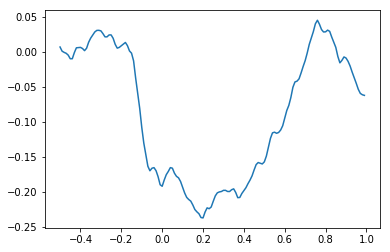

In [66]:
plt.plot(epochs.times,a.T.mean(1))

In [0]:
gen = []
for ii in range(timesteps):
    X_in,y_in = X[idx_test],targets[idx_test]
    X_repeat = X_in.copy()
    for jj in range(timesteps):
        X_repeat[:,jj,:] = X_in[:,ii,:]
    X_repeat,y_repeat = prepare_data_batch(X_repeat,y_in,batch_size)
    X_temp = np.concatenate([features([temp])[0] for temp in X_repeat.reshape(-1,batch_size,timesteps,data_dim)])
    gen.append(X_temp)
gen = np.array(gen)

In [85]:
gen.shape

(150, 70, 150)

In [0]:
gen_ave = gen.mean(1)

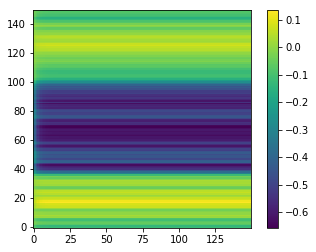

In [88]:
im = plt.imshow(gen_ave,origin = 'lower')
plt.colorbar(im)

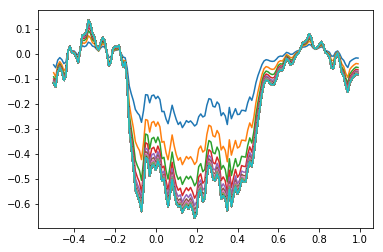

In [93]:
_=plt.plot(epochs.times,gen_ave)